<a href="https://colab.research.google.com/github/v3nkyc0d3z/Deeplearning-with-tensorflow.keras/blob/master/Deep_Dream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import tensorflow as tf
import numpy as np
import PIL.Image
import IPython.display as display
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from datetime import datetime
import os
import cv2

(328, 500, 3)


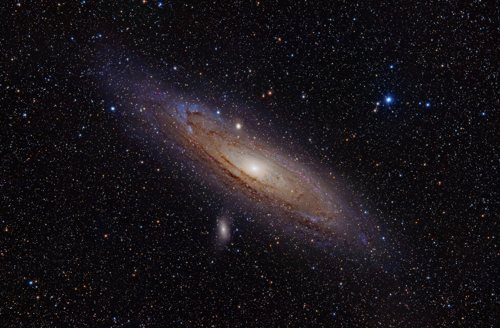

In [55]:
url = "https://upload.wikimedia.org/wikipedia/commons/9/98/Andromeda_Galaxy_%28with_h-alpha%29.jpg"
def get_image(url,size=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name,origin = url)
  img = PIL.Image.open(image_path)
  if size:
    img.thumbnail((size,size))
  return np.array(img)
  
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

andromeda = get_image(url,500)
print(np.shape(andromeda))
show(andromeda)


In [56]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

In [103]:
layer_name = ["mixed4"]
layers = [base_model.get_layer(name).output for name in layer_name]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [104]:
def loss_fn(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [105]:
class DeepDream(tf.Module):
  def __init__(self,model):
    self.model = model
  def __call__ (self,image,steps,step_size):
    loss = tf.constant(0.0)
    for n in tf.range(steps):
      with tf.GradientTape() as tape:
        tape.watch(image)
        loss = loss_fn(image,self.model)
      gradient = tape.gradient(loss,image)
      gradient /=  tf.math.reduce_std(gradient)+ 1e-8
      image += gradient*step_size
      image = tf.clip_by_value(image,-1,1)
    return image,loss

In [106]:
deepdream = DeepDream(dream_model)

In [107]:
def execution(image,steps= 5,step_size = 0.01):
  dir = "saved_images"
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  image = tf.convert_to_tensor(image)
  step_size = tf.convert_to_tensor(step_size)
  current_step = 0
  while current_step<steps:
    now = str(datetime.now())
    fname = os.path.join(dir,"Image_"+now+".png")
    img, loss = deepdream(image, current_step, tf.constant(step_size))
    display.clear_output(wait=True)
    target = deprocess(img)
    show(target)
    pil_img = PIL.Image.fromarray(np.array(target))
    pil_img.save(fname)
    print ("Step {}, loss {}".format(current_step, loss))
    current_step += 1
  result = deprocess(img)

  display.clear_output(wait=True)
  show(result)
  
  return result

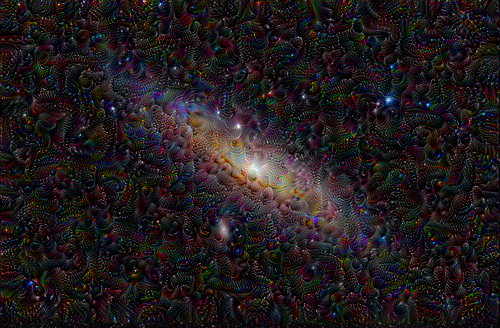

In [95]:
dream_img = execution(image=andromeda,steps=100, step_size=0.01)

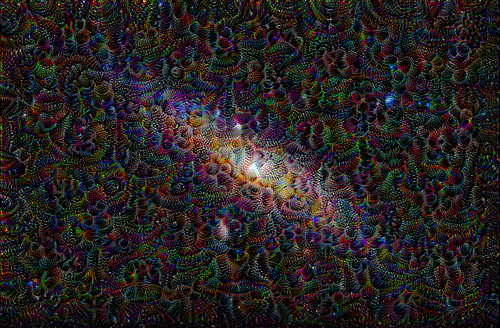

In [109]:
dream_img = execution(image=tf.cast(dream_img,tf.float32),steps=100, step_size=0.01)

In [108]:
import glob
filenames = os.listdir("saved_images")
img_array = []
for filename in glob.glob('saved_images/*.png'):
  img = cv2.imread(filename)
  height, width, layers = img.shape
  size = (width,height)
  img_array.append(img)

out = cv2.VideoWriter('project.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

for image in img_array:
  out.write(image)
out.release()

In [110]:
!zip -r /content/deep_dream.zip /content/saved_images

  adding: content/saved_images/ (stored 0%)
  adding: content/saved_images/Image_2020-09-20 17:09:44.735542.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:12:19.954427.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:08:27.721269.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:20:02.121260.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:07:50.446172.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:19:13.644386.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:08:32.895763.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:07:52.355850.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:17:59.416138.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:07:45.380262.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:19:13.157797.png (deflated 0%)
  adding: content/saved_images/Image_2020-09-20 17:12:

In [91]:
!rm -rf saved_images